In [1]:
import numpy as np
import pandas as pd
import random
import jieba
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from utils import DATA_TEXT_SEQUENCES_PATH, DATA_LABELS_PATH
from utils import DATA_W2V_VECTOR_PATH, DATA_W2V_META_PATH
from utils import CustomIterator

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


2022-04-11 19:19:07.827582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-11 19:19:10.161325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1408 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:18:00.0, compute capability: 8.6
2022-04-11 19:19:10.162211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1628 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-04-11 19:19:10.162957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

In [3]:
with open(DATA_W2V_VECTOR_PATH, 'r') as vf:
    with open(DATA_W2V_META_PATH, 'r') as mf:
        w2v_vector = np.loadtxt(vf)
        w2v_meta = pd.read_csv(mf, sep='\t', header=None)

word2index = dict([(row[0], idx + 3) for idx, row in w2v_meta.iterrows()])
word2index['<PAD>'] = 0
word2index['<START>'] = 1
word2index['<UNK>'] = 2
word2index['<UNUSED>'] = 3

index2word = dict([(i, w) for w, i in word2index.items()])

def decode_review(seq):
    return ' '.join([index2word.get(i, '?') for i in seq])

def encode_review(words):
    return [word2index.get(w, 2) for w in words]


text_sequences = pickle.load(open(DATA_TEXT_SEQUENCES_PATH, 'rb'))
labels = pickle.load(open(DATA_LABELS_PATH, 'rb'))

print(text_sequences[0])
print(encode_review(text_sequences[0]))
# print(decode_review(sequences[0]))

['标准', '美国', '科幻', '大片', '。', '参考', '影片', '《', '世界末日', ' ', 'Armageddon', ' ', '(', '1998', ')', '》']
[1276, 258, 521, 1250, 6, 3912, 125, 23, 2, 2, 2, 2, 2, 2, 2, 24]


In [4]:
vocab_size = len(word2index) + 3
vector_length = len(w2v_vector[0])

embeddings_matrix = np.array([np.zeros(vector_length) for _ in range(3)] + [w2v_vector[i - 3] for w, i in word2index.items()])

print(embeddings_matrix.shape, vocab_size, vector_length)

# embeddings_matrix = embeddings_matrix.tolist()

(4102, 256) 4102 256


In [5]:
assert(len(text_sequences) == len(labels))

val_size = 0.25

idx = list(range(len(labels)))

random.shuffle(idx)

dataset_train_idx, dataset_val_idx = idx[int(val_size * len(idx)):], idx[:int(val_size * len(idx))]

train_data = [[word2index.get(w, 0) for w in text_sequences[i]] for i in dataset_train_idx]
val_data = [[word2index.get(w, 0) for w in text_sequences[i]] for i in dataset_val_idx]

train_labels = [labels[i] for i in dataset_train_idx]
val_labels = [labels[i] for i in dataset_val_idx]

In [6]:
# MAX_SEQUENCE_LENGTH = 128
MAX_SEQUENCE_LENGTH = 68

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word2index["<PAD>"],
                                                        padding='post',
                                                        maxlen=MAX_SEQUENCE_LENGTH)

val_data = keras.preprocessing.sequence.pad_sequences(val_data,
                                                      value=word2index["<PAD>"],
                                                      padding='post',
                                                      maxlen=MAX_SEQUENCE_LENGTH)

In [7]:

train_data = np.array(train_data).astype(np.int32)
val_data = np.array(val_data).astype(np.int32)

train_labels = np.array(train_labels).astype(np.float32)
val_labels = np.array(val_labels).astype(np.float32)

In [8]:
print(train_data[0])

[1396    4 1046  735    5 2024 1250    4  243  562  452  372    5  858
    6    0   15  629   40 1070    4 2509    8 2682  256    5    0 1183
    4 3369    0   43   50  726  401    0   45   13    0    5 1240  116
   35   39   14    5 3026 1559    6   31  200    8  540   41  220  105
    5  157  437    5   14    7    4  363  651    0 1396   21]


In [9]:
print(train_labels)

[4. 4. 3. ... 2. 3. 4.]


## Train

In [10]:
model = keras.Sequential()

embedding_layer = keras.layers.Embedding(vocab_size,
                            vector_length, 
                            weights=[embeddings_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False
                            )


model.add(embedding_layer)
model.add(keras.layers.GlobalAveragePooling1D())
# model.add(keras.layers.Dense(vector_length, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 68, 256)           1050112   
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,214,593
Trainable params: 164,481
Non-trainable params: 1,050,112
________________________________________

In [11]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_data, val_labels),
                    verbose=1)

Epoch 1/20
30/33 [==========================>...] - ETA: 0s - loss: 5.8747 - accuracy: 0.0403    

2022-04-11 19:19:14.060206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


33/33 [==============================] - 2s 11ms/step - loss: 5.7049 - accuracy: 0.0417 - val_loss: 3.1953 - val_accuracy: 0.0603
Epoch 2/20
33/33 [==============================] - 0s 5ms/step - loss: 2.3500 - accuracy: 0.0549 - val_loss: 1.4267 - val_accuracy: 0.0603
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 1.1750 - accuracy: 0.0549 - val_loss: 1.1235 - val_accuracy: 0.0603
Epoch 4/20
33/33 [==============================] - 0s 5ms/step - loss: 1.0934 - accuracy: 0.0549 - val_loss: 1.1114 - val_accuracy: 0.0603
Epoch 5/20
33/33 [==============================] - 0s 5ms/step - loss: 1.0814 - accuracy: 0.0549 - val_loss: 1.1102 - val_accuracy: 0.0603
Epoch 6/20
33/33 [==============================] - 0s 5ms/step - loss: 1.0802 - accuracy: 0.0549 - val_loss: 1.1108 - val_accuracy: 0.0603
Epoch 7/20
33/33 [==============================] - 0s 5ms/step - loss: 1.0735 - accuracy: 0.0549 - val_loss: 1.1223 - val_accuracy: 0.0603
Epoch 8/20
33/33 [============

In [13]:
results = model.evaluate(val_data,  val_labels, verbose=2)

print(results)

172/172 - 0s - loss: 1.1257 - accuracy: 0.0603 - 405ms/epoch - 2ms/step
[1.125712275505066, 0.06034639850258827]


In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

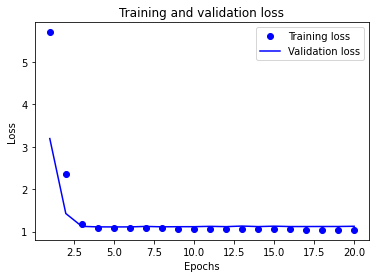

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()